# Analysis of the risk of bitcoin

## Setup

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal

In [2]:
# Get bitcoin price df and set date as index
df_btc = pd.read_csv("../data/BTC.csv", index_col="date", parse_dates=True)

In [3]:
# Set charts theme
sns.set_theme(style="darkgrid", rc={"grid.alpha": 0.33})
plt.style.use("dark_background")

# Save chart as png function
def save_chart_as_png(filename: str) -> None:
    plt.savefig(
        f"../images/{filename}.png",
        format="png",
        dpi=300,
        orientation="landscape",
        bbox_inches="tight",
    )

In [4]:
# Get OHLC average as price
df_btc["price"] = df_btc[["open", "high", "low", "close"]].mean(axis=1)
df_btc.drop(columns=["open", "high", "low", "close"], inplace=True)

## Volatility of bitcoin across time (EWMA method)

In [5]:
# Get log price change
df_btc["price_change_log"] = np.log(df_btc["price"] / df_btc["price"].shift(1))

In [6]:
# Biggest price changes
df_btc.loc[df_btc["price_change_log"].abs().sort_values(ascending=False).head(10).index, ["price_change_log"]].T

date,2011-06-11,2011-05-10,2010-11-06,2011-08-06,2012-08-19,2010-11-08,2013-04-10,2011-10-17,2013-04-17,2011-11-14
price_change_log,-0.49144,0.42458,0.405465,-0.402907,-0.372425,-0.335884,-0.332134,-0.32891,0.308627,-0.300071


In [7]:
# Get 90-day and 1-year volatility with the exponentially weighted moving average (EWMA) method
df_btc["volatility_90d"] = df_btc["price_change_log"].ewm(span=90).std()
df_btc["volatility_1y"] = df_btc["price_change_log"].ewm(span=365).std()

In [8]:
# Change first cycle values to NaN to avoid having unreliable volatility measures
df_btc.loc[:df_btc.index[364], "volatility_1y"] = np.nan
df_btc.loc[:df_btc.index[89], "volatility_90d"] = np.nan

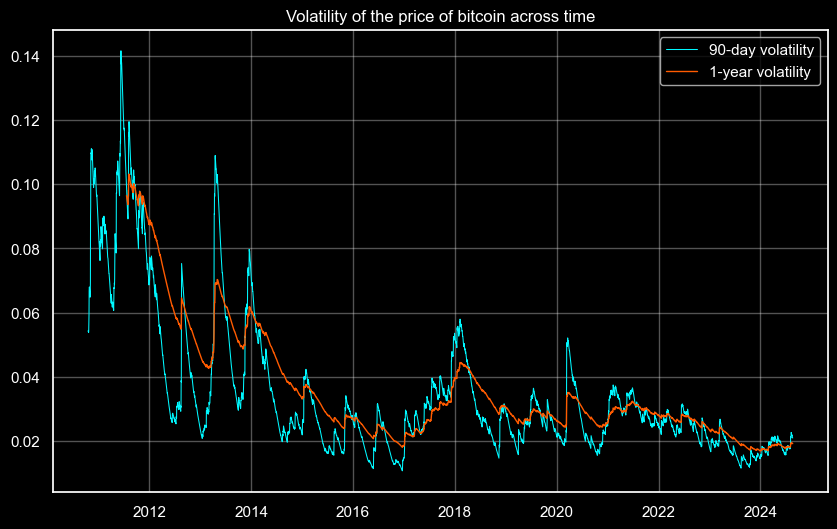

In [9]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_btc, x=df_btc.index, y="volatility_90d", label="90-day volatility", color="#00f8ff", linewidth=0.75)
sns.lineplot(data=df_btc, x=df_btc.index, y="volatility_1y", label="1-year volatility", color="#ff5b00", linewidth=1)

plt.title("Volatility of the price of bitcoin across time")
plt.xlabel("")
plt.ylabel("")

save_chart_as_png("2_BTC_vlt")

In [10]:
# All-time high 1-year volatility
ath_date = df_btc["volatility_1y"].idxmax()
df_btc.loc[[ath_date], ["price", "volatility_1y"]]

,price,volatility_1y
date,,
2011-08-09,9.99,0.103198


In [11]:
# All-time low 1-year volatility
atl_date = df_btc["volatility_1y"].idxmin()
df_btc.loc[[atl_date], ["price", "volatility_1y"]]

,price,volatility_1y
date,,
2023-12-31,42294.65,0.016885


In [12]:
# Top 5 peaks of 1-year volatility
peaks, _ = signal.find_peaks(df_btc["volatility_1y"], distance=500)
df_btc.iloc[peaks].nlargest(5, "volatility_1y").sort_values("date")[["volatility_1y"]].T

date,2011-08-09,2013-05-03,2014-09-19,2018-02-07,2020-03-24
volatility_1y,0.103198,0.070326,0.0386,0.044474,0.035102


In [13]:
# Top 5 valleys of 1-year volatility
valleys, _ = signal.find_peaks(-df_btc["volatility_1y"], distance=500)
df_btc.iloc[valleys].nsmallest(5, "volatility_1y").sort_values("date")[["volatility_1y"]].T

date,2016-12-20,2019-05-08,2020-11-04,2022-06-10,2023-12-31
volatility_1y,0.018016,0.025224,0.024266,0.025753,0.016885


In [14]:
# Average 1-year volatility
df_btc["volatility_1y"].mean().round(3)

0.036

**Key takeaways:**
- ...

### Comparison of volatility with other assets

**Key takeaways:**
- ...

## Yearly volatility across time

In [15]:
# Group by year and get standard deviation of price change along with the number of days
df_btc_yearly = df_btc.groupby(df_btc.index.year).agg(
    volatility=("price_change_log", "std"),
    num_days=("price_change_log", "count"),
)

In [16]:
# Annualize the volatility for incomplete years (2010 and 2024), multiplying by the square root of the division of 365 by number of days
df_btc_yearly.loc[df_btc_yearly["num_days"] < 365, "volatility"] *= (365 / df_btc_yearly["num_days"])**0.5

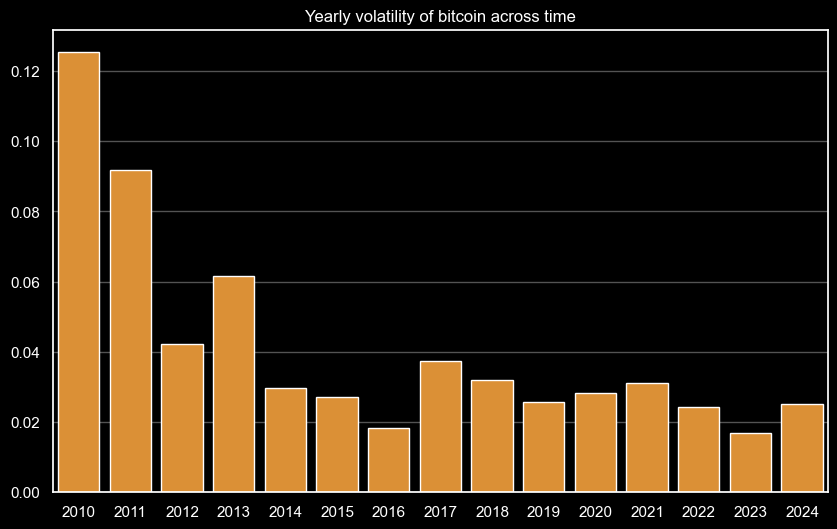

In [17]:
plt.figure(figsize=(10, 6))

sns.barplot(data=df_btc_yearly, x=df_btc_yearly.index, y="volatility", color="#f7931a")

plt.title("Yearly volatility of bitcoin across time")
plt.xlabel("")
plt.ylabel("")

save_chart_as_png("2_BTC_yearly_vlt")

In [18]:
# Create table with yearly volatility stats
pd.DataFrame({
    "Average yearly volatility": [round(df_btc_yearly["volatility"].mean(), 4)],
    "Median yearly volatility": [round(df_btc_yearly["volatility"].median(), 4)],
    "Standard deviation": [round(df_btc_yearly["volatility"].std(), 4)],
    "Min yearly volatility": [round(df_btc_yearly["volatility"].min(), 4)],
    "Max yearly volatility": [round(df_btc_yearly["volatility"].max(), 4)],
})

,Average yearly volatility,Median yearly volatility,Standard deviation,Min yearly volatility,Max yearly volatility
0,0.0411,0.0295,0.0302,0.0168,0.1255


**Key takeaways:**
- ...

## Volatility vs price (90-day rolling values)

In [19]:
# Get 90-day moving average price
df_btc["price_90d_ma"] = df_btc["price"].rolling(window=90).mean()

In [20]:
# Get 90-day rolling volatility with the standard deviation method
df_btc["volatility_90d_mstd"] = df_btc["price_change_log"].rolling(window=90).std()

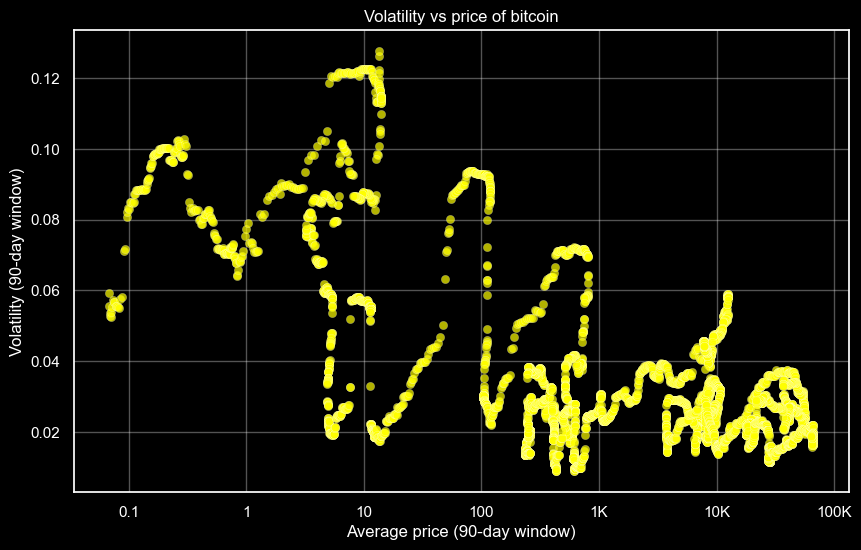

In [21]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df_btc, x="price_90d_ma", y="volatility_90d_mstd", alpha=0.7, linewidth=0.2, color="yellow")

plt.title("Volatility vs price of bitcoin")
plt.xlabel("Average price (90-day window)")
plt.ylabel("Volatility (90-day window)")

plt.xscale("log")

plt.gca().xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f"{int(x)}" if x < 1000 and x.is_integer()
                  else (f"{x:.1f}" if x < 1 else f"{int(x/1000)}K"))
)

save_chart_as_png("2_BTC_vlt_vs_price")

In [22]:
# Pearson correlation coefficient betweent volatility and price
df_btc["price_90d_ma"].corr(df_btc["volatility_90d_mstd"]).round(2)

-0.3

**Key takeaways:**
- ...